In [ ]:
from lime import lime_image
import torch
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

import cv2
import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import pickle
import os
import argparse
import matplotlib.pyplot as plt
from matplotlib import cm
import PIL
from IPython import embed
import timm
import torch.nn.functional as F
import torchvision.utils as utils
from torchsummary import summary

import torch
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.io import read_image
import glob
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.io import read_image
import glob
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [10]:
checkpoint = torch.load('./CelebDF.pt',map_location=torch.device('cuda'))
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [44]:
class CustomDataset(Dataset):
	def __init__(self, transform=None):
		self.imgs_path = './Celeb-DF-v2_images/'
		self.transform = transform
		file_list = glob.glob(self.imgs_path + "*")
		
		self.data = []
		for class_path in file_list:
			# class_name = class_path.split("\\")[-1]
			class_name = class_path.split("/")[-1]
			print(class_name)
			for img_path in glob.glob(class_path + "/*.jpg"):
				self.data.append([img_path, class_name])
			
		self.class_map = {"Celeb-real_images": 0, "Celeb-synthesis_images": 1}
	
	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		img_path, class_name = self.data[idx]
		img = read_image(img_path)
		class_id = self.class_map[class_name]
		class_id = torch.tensor([class_id])

		# Transform if necessary
		if self.transform:
				img_tensor = self.transform(img)
		return img_tensor, class_id

In [45]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
     ])

dataset = CustomDataset(transform=train_transforms)
train_size = int(0.96 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])	

Celeb-synthesis_images
Celeb-real_images


In [46]:
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [47]:
print(len(test_data_loader))


154


In [48]:
model.eval()
predicted_labels = []
actual_labels = []

with torch.no_grad():
    for i, data in enumerate(test_data_loader):
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        output = torch.sigmoid(output)
        predicted_label = (output > 0.5).int()
        predicted_labels.append(predicted_label.item())
        actual_labels.append(labels.item())
        print (output.item(), '     ',predicted_label)

2.639394779180293e-06       tensor([[0]], device='cuda:0', dtype=torch.int32)
0.9999834299087524       tensor([[1]], device='cuda:0', dtype=torch.int32)
0.9999876022338867       tensor([[1]], device='cuda:0', dtype=torch.int32)
0.9999960660934448       tensor([[1]], device='cuda:0', dtype=torch.int32)
3.67273491974629e-06       tensor([[0]], device='cuda:0', dtype=torch.int32)
0.9999828338623047       tensor([[1]], device='cuda:0', dtype=torch.int32)
0.9999837875366211       tensor([[1]], device='cuda:0', dtype=torch.int32)
0.9999803304672241       tensor([[1]], device='cuda:0', dtype=torch.int32)
0.9999822378158569       tensor([[1]], device='cuda:0', dtype=torch.int32)
0.9999295473098755       tensor([[1]], device='cuda:0', dtype=torch.int32)
0.9999748468399048       tensor([[1]], device='cuda:0', dtype=torch.int32)
0.999990701675415       tensor([[1]], device='cuda:0', dtype=torch.int32)
0.9999561309814453       tensor([[1]], device='cuda:0', dtype=torch.int32)
0.9999258518218994   

In [51]:
print("Predicted labels:")
print(predicted_labels[:20])
print("Actual labels:")
print(actual_labels[:20])

print(classification_report(actual_labels, predicted_labels))

Predicted labels:
[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
Actual labels:
[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        31
           1       0.98      0.98      0.98       123

    accuracy                           0.97       154
   macro avg       0.94      0.96      0.95       154
weighted avg       0.97      0.97      0.97       154



Precision:  0.9836065573770492
Recall:  0.975609756097561
F1 score:  0.9795918367346939


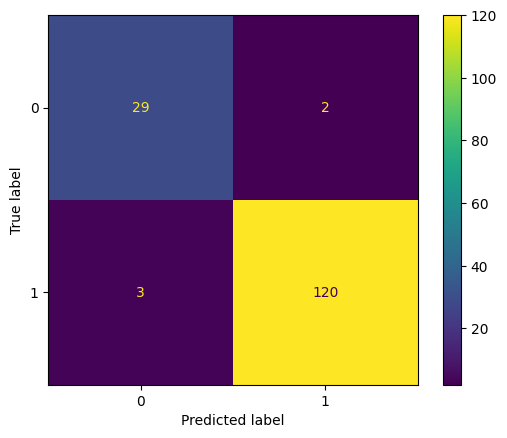

In [52]:
# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Compute precision and recall
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]
precision = tp / (tp + fp)
print("Precision: ", precision)

recall = tp / (tp + fn)
print("Recall: ",recall)
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 score: ",f1_score)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

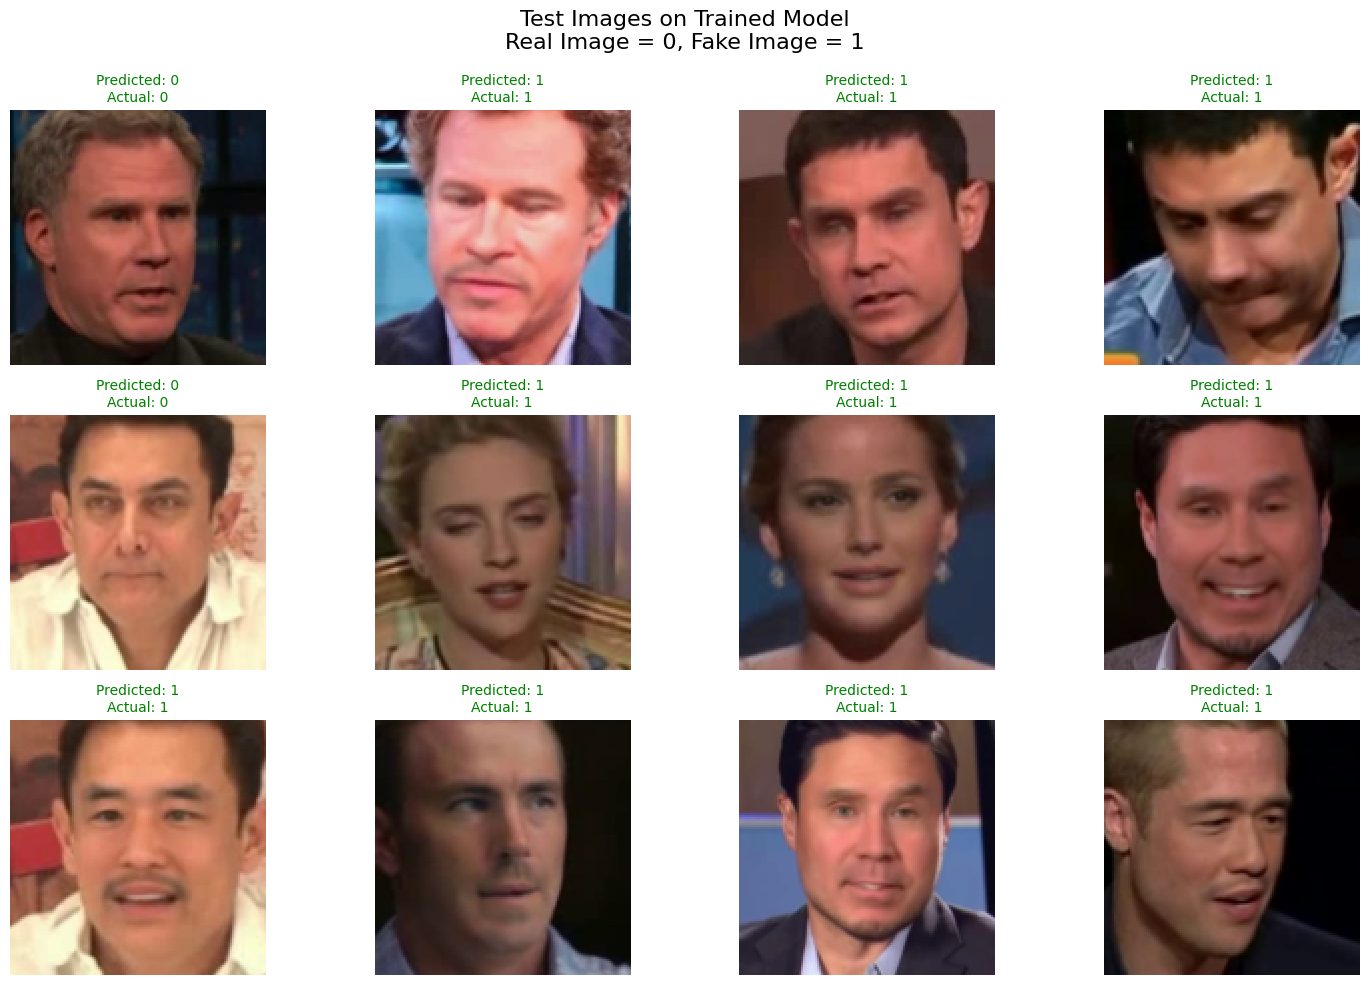

In [67]:
import matplotlib.pyplot as plt
import numpy as np

def plot_test_images(test_data_loader, predicted_labels, actual_labels, num_images=12):
    """
    Test görüntülerini tahmin edilen ve gerçek etiketlerle birlikte gösterir.
    
    Parameters:
    - test_data_loader: PyTorch DataLoader nesnesi, test verilerini içerir.
    - predicted_labels: Tahmin edilen etiketlerin listesi veya dizisi.
    - actual_labels: Gerçek etiketlerin listesi veya dizisi.
    - num_images: Gösterilecek toplam görüntü sayısı (varsayılan 12).
    """
    predicted_labels = np.array(predicted_labels)
    actual_labels = np.array(actual_labels)
    
    num_images = min(num_images, len(predicted_labels), len(actual_labels))
    
    cols = 4
    rows = 3
    fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
    fig.suptitle('Test Images on Trained Model\nReal Image = 0, Fake Image = 1', fontsize=16)
    
    axs = axs.flatten()
    
    img_idx = 0  # Görüntü sayacı
    for batch in test_data_loader:
        data, labels = batch  # Veriyi ve etiketleri al
        batch_size = data.size(0)
        
        for i in range(batch_size):
            if img_idx >= num_images:
                break  # İstenen sayıda görüntü gösterildi
            
            # Görüntüyü CPU'ya taşı ve NumPy dizisine çevir
            image = data[i].cpu().numpy().transpose((1, 2, 0))
            
            # Görüntüyü [0, 1] aralığına normalize et (gerekiyorsa)
            image = np.clip(image, 0, 1)
            
            # Görüntüyü subplot üzerine ekle
            axs[img_idx].imshow(image)
            axs[img_idx].axis('off')  # Eksenleri gizle
            
            # Başlık olarak tahmin edilen ve gerçek etiketleri ekle
            predicted = predicted_labels[img_idx]
            actual = actual_labels[img_idx]
            title_color = 'green' if predicted == actual else 'red'  # Doğruysa yeşil, yanlışsa kırmızı
            axs[img_idx].set_title(f'Predicted: {predicted}\nActual: {actual}', fontsize=10, color=title_color)
            
            img_idx += 1  # Sayacı artır
    
        if img_idx >= num_images:
            break  # İstenen sayıda görüntü gösterildi
    
    # Kalan subplotları gizle (eğer varsa)
    for j in range(img_idx, rows * cols):
        axs[j].axis('off')
    
    # Düzenlemeleri yap
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # Genel başlık için yer bırak
    plt.savefig("predicted.png")
    plt.show()
    
plot_test_images(test_data_loader, predicted_labels, actual_labels, num_images=12)


In [ ]:
model_ffpp = torch.load('/content/drive/MyDrive/ECE_792_PROJECT/plot_curves/FFPP_model_20_epochs_99acc.pt')
model_celebdf = torch.load('/content/drive/MyDrive/ECE_792_PROJECT/plot_curves/CelebDF_model_20_epochs_99acc.pt')

celebdf_loss = model_celebdf['loss']
celebdf_accuracy = model_celebdf['accuracy']

ffpp_loss = model_ffpp['loss']
ffpp_accuracy = model_ffpp['accuracy']

In [ ]:
def plot_curves(train_losses, train_accuracies, test_losses, test_accuracies):

  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

  # Plot the train and test losses
  ax1.plot(train_losses, label='Train')
  ax1.plot(test_losses, label='Test')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.set_title('Train/Test Losses')
  ax1.legend()

  # Plot the train and test accuracies
  ax2.plot(train_accuracies, label='Train')
  ax2.plot(test_accuracies, label='Test')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Train/Test Accuracies')
  ax2.legend()

  # Show the plot
  plt.show()
  
plot_curves(ffpp_loss, ffpp_accuracy, celebdf_loss, celebdf_accuracy)

NameError: name 'ffpp_loss' is not defined

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/792_model/CelebDF_model_20_epochs_99acc.pt',map_location=torch.device('cpu'))
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
model.eval()

In [ ]:
class CustomDataset(Dataset):
	def __init__(self, transform=None):
		self.imgs_path = '/content/drive/MyDrive/Celeb_DF_dataset/'
		self.transform = transform
		file_list = glob.glob(self.imgs_path + "*")
		
		self.data = []
		for class_path in file_list:
			# class_name = class_path.split("\\")[-1]
			class_name = class_path.split("/")[-1]
			print(class_name)
			for img_path in glob.glob(class_path + "/*.jpg"):
				self.data.append([img_path, class_name])
			
		self.class_map = {"Celeb-real-images": 0, "Celeb-synthetic-images": 1}
	
	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		img_path, class_name = self.data[idx]
		img = read_image(img_path)
		class_id = self.class_map[class_name]
		class_id = torch.tensor([class_id])

		# Transform if necessary
		if self.transform:
				img_tensor = self.transform(img)
		return img_tensor, class_id

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
     ])

dataset = CustomDataset(transform=train_transforms)
train_size = int(0.96 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])	

train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_data_loader)

In [ ]:
model.eval()
predicted_labels = []
actual_labels = []

with torch.no_grad():
    for i, data in enumerate(test_data_loader):
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        output = torch.sigmoid(output)
        predicted_label = (output > 0.5).int()
        predicted_labels.append(predicted_label.item())
        actual_labels.append(labels.item())
        print (output.item(), '     ',predicted_label)

In [ ]:
predicted_labels[:20]
actual_labels[:20]

print(classification_report(actual_labels, predicted_labels))

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Compute precision and recall
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]
precision = tp / (tp + fp)
print("Precision: ", precision)

recall = tp / (tp + fn)
print("Recall: ",recall)
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 score: ",f1_score)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
predicted_labels = np.array(predicted_labels)
actual_labels = np.array(actual_labels)
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle('Test Images on Trained Model\n Real Image = 0, Fake Image = 1', fontsize=16)
for i, (data, label) in enumerate(test_data_loader):
    ax = axs[i//4, i%4]
    ax.imshow(np.transpose(data.squeeze().numpy(), (1, 2, 0)))
    ax.axis('off')
    ax.set_title(f'Predicted: {predicted_labels[i]}, Actual: {actual_labels[i]}')
    if i == 11:
        break

plt.show()